# LeNet-5 with Sharpness-aware minimization

In [26]:
# 우선, MNIST dataset에 적용할 transformation 객체를 생성합니다.
from torchvision import transforms
import torch
import copy

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


cuda


### 1. Training & Validation 데이터셋 준비

변형 없는 transformation 정의

In [27]:
# transformation 정의하기
data_transform = transforms.Compose([
            #transforms.Resize((32, 32)),
            transforms.ToTensor(),
])

get_train_valid_loader 함수는 MNIST Training 데이터셋을 split하여 Training dataset과 Validation dataset을 리턴함.

In [28]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler


def get_train_valid_loader(data_dir,
                           batch_size,
                           random_seed,
                           augment=False,
                           valid_size=0.2,
                           shuffle=True,
                           num_workers=1,
                           pin_memory=True):
    """
    Utility function for loading and returning train and valid 
    multi-process iterators over the MNIST dataset. A sample 
    9x9 grid of the images can be optionally displayed.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize((0.1307,), (0.3081,))  # MNIST

    '''
    # define transforms
    valid_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize
        ])
    if augment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize
        ])
    else:
        train_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize
        ])
    '''

    # load the dataset
    train_dataset = datasets.MNIST(root=data_dir, train=True, 
                download=True, transform=data_transform)

    valid_dataset = datasets.MNIST(root=data_dir, train=True, 
                download=True, transform=data_transform)

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(train_dataset, 
                    batch_size=batch_size, sampler=train_sampler, 
                    num_workers=num_workers, pin_memory=pin_memory)

    valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                    batch_size=batch_size, sampler=valid_sampler, 
                    num_workers=num_workers, pin_memory=pin_memory)

    return (train_dataset, train_loader, valid_dataset, valid_loader)

In [29]:
# MNIST training dataset 불러오기
from torchvision import datasets

# 데이터를 저장할 경로 설정
path2data = './data'

In [30]:
# data loader 를 생성합니다.
from torch.utils.data import DataLoader

train_data, train_dl, val_data, val_dl = get_train_valid_loader(path2data, 128, random_seed=np.random.seed(100), augment=False, valid_size=0.2, shuffle=True)

Validation dataset의 비율을 0.2로 설정하였으므로  
Training dataset과 Validation dataset 비율은 8:2.  

Training dataset : 48000  
Validation dataset : 12000  

Sample 이미지 확인

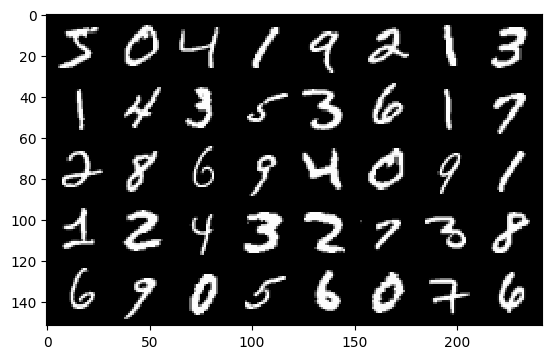

In [31]:
# sample images를 확인합니다.
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# training data를 추출합니다.
x_train, y_train = train_data.data, train_data.targets

# val data를 추출합니다.
x_val, y_val = val_data.data, val_data.targets

# 차원을 추가하여 B*C*H*W 가 되도록 합니다.
if len(x_train.shape) == 3:
    x_train = x_train.unsqueeze(1)

if len(x_val.shape) == 3:
    x_val = x_val.unsqueeze(1)

# tensor를 image로 변경하는 함수를 정의합니다.
def show(img):
    # tensor를 numpy array로 변경합니다.
    npimg = img.numpy()
    # C*H*W를 H*W*C로 변경합니다.
    npimg_tr = npimg.transpose((1,2,0))
    plt.imshow(npimg_tr, interpolation='nearest')

# images grid를 생성하고 출력합니다.
# 총 40개 이미지, 행당 8개 이미지를 출력합니다.
x_grid = utils.make_grid(x_train[:40], nrow=8, padding=2)

show(x_grid)

### 2. LeNet-5 모델 정의

In [4]:
from torch import nn
import torch.nn.functional as F

class LeNet_5(nn.Module):
    def __init__(self):
        super(LeNet_5,self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.tanh(self.conv1(x))
        x = F.avg_pool2d(x, 2, 2)
        x = F.tanh(self.conv2(x))
        x = F.avg_pool2d(x, 2, 2)
        x = F.tanh(self.conv3(x))
        x = x.view(-1, 120)
        x = F.tanh(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


### 3. 하이퍼파라미터 설정 및 학습

Loss function 정의

In [33]:
def smooth_crossentropy(pred, gold, smoothing=0.1):
    n_class = pred.size(1)

    one_hot = torch.full_like(pred, fill_value=smoothing / (n_class - 1))
    one_hot.scatter_(dim=1, index=gold.unsqueeze(1), value=1.0 - smoothing)
    log_prob = F.log_softmax(pred, dim=1)

    return F.kl_div(input=log_prob, target=one_hot, reduction='none').sum(-1)

SAM + SGD + momentum 조합으로 학습시킴.  
LR 함수로는 LR이 계단형으로 증가하는 StepLR 사용함.  
  
SAM Optimizer는 첫 번째 Step과 두 번째 Step이 있음.  
첫 번째 Step : 로컬 `rho`-neighbor에서 손실이 가장 큰 가중치를 찾는 첫 번째 최적화 단계를 수행.  
두 번째 Step : Loss landscape에서 (로컬적으로) 가장 높은 지점의 기울기로 원래 가중치를 업데이트하는 두 번째 최적화 단계를 수행.  
  
배치 크기 : 128  
에폭 수 : 80  
초기 LR : 0.1

In [34]:
import torch

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)    
from utility.log import Log
from utility.initialize import initialize
from utility.step_lr import StepLR
from utility.bypass_bn import enable_running_stats, disable_running_stats

import sys; sys.path.append("..")
from sam import SAM


args = dict()
args['adaptive'] = True
args['batch_size'] = 128
args['epochs'] = 80
args['label_smoothing'] = 0.1
args['learning_rate'] = 0.1
args['momentum'] = 0.9
args['threads'] = 2
args['rho'] = 2.0
args['weight_decay'] = 0.0005

initialize(args, seed=42)

log = Log(log_each=10)
model = LeNet_5().to(device)
print(model)

base_optimizer = torch.optim.SGD
optimizer = SAM(model.parameters(), base_optimizer, rho=args['rho'], adaptive=args['adaptive'], lr=args['learning_rate'], momentum=args['momentum'], weight_decay=args['weight_decay'])
scheduler = StepLR(optimizer, args['learning_rate'], args['epochs'])

for epoch in range(args['epochs']):
    model.train()
    log.train(len_dataset=len(train_dl))

    for batch in train_dl:
        inputs, targets = (b.to(device) for b in batch)

        # first forward-backward step
        enable_running_stats(model)
        predictions = model(inputs)
        loss = smooth_crossentropy(predictions, targets, smoothing=args['label_smoothing'])
        loss.mean().backward()
        optimizer.first_step(zero_grad=True)

        # second forward-backward step
        disable_running_stats(model)
        smooth_crossentropy(model(inputs), targets, smoothing=args['label_smoothing']).mean().backward()
        optimizer.second_step(zero_grad=True)

        with torch.no_grad():
            correct = torch.argmax(predictions.data, 1) == targets
            log(model, loss.cpu(), correct.cpu(), scheduler.lr())
            scheduler(epoch)

    model.eval()
    log.eval(len_dataset=len(val_dl))

    with torch.no_grad():
        for batch in val_dl:
            inputs, targets = (b.to(device) for b in batch)

            predictions = model(inputs)
            loss = smooth_crossentropy(predictions, targets)
            correct = torch.argmax(predictions, 1) == targets
            log(model, loss.cpu(), correct.cpu())

log.flush()

LeNet_5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)
┏━━━━━━━━━━━━━━┳━━━━━━━╸T╺╸R╺╸A╺╸I╺╸N╺━━━━━━━┳━━━━━━━╸S╺╸T╺╸A╺╸T╺╸S╺━━━━━━━┳━━━━━━━╸V╺╸A╺╸L╺╸I╺╸D╺━━━━━━━┓
┃              ┃              ╷              ┃              ╷              ┃              ╷              ┃
┃       epoch  ┃        loss  │    accuracy  ┃        l.r.  │     elapsed  ┃        loss  │    accuracy  ┃
┠──────────────╂──────────────┼──────────────╂──────────────┼──────────────╂──────────────┼──────────────┨
┃           0  ┃      0.3112  │     88.56 %  ┃   1.000e-01  │   00:09 min  ┃┈██████████████████████████▒┈┨      0.1113  │     96.34 %  ┃
┃           1  ┃      0.0923  │     97.14 %  ┃   1.000e-01  │   00:09 min  ┃┈██████████████████████████▒┈┨

위에서 학습시킨 모델 저장

In [35]:
import os.path

number_of_epochs = args['epochs']
batch_size = args['batch_size']

if os.path.isfile(f'./model/epochs-{number_of_epochs}/LeNet-5_SAM_b{batch_size}.pth') == False:
    torch.save(model, f'./model/epochs-{number_of_epochs}/LeNet-5_SAM_b{batch_size}.pth')
else:
    print('cannot save into file.')

### 4. Test 데이터셋 준비 및 테스트

저장된 모델 불러오기

In [11]:
import torch

model = torch.load('./model/epochs-80/LeNet-5_SAM_b128.pth')
model.to(device)
model.eval()

LeNet_5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

정확도 측정 함수 정의

In [12]:
def check_accuracy(loader, model):
    
    correct_list=[]
    wrong_list=[]

    total = 0
    correct = 0  # 정답 개수를 기록하기 위한 변수

    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            infer = model(inputs)
            predicted = infer.argmax(dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # 올바르게 분류된 샘플과 잘못 분류된 샘플을 구분하여 저장
            for i in range(len(predicted)):
                if predicted[i] == labels[i]:
                    correct_list.append((inputs[i], labels[i], predicted[i]))
                else:
                    wrong_list.append((inputs[i], labels[i], predicted[i]))

    # 정확도 출력
    accuracy = 100 * correct / total
    print(f'Accuracy on the test set: {accuracy:.3f}%')

    # 옳게 분류된 샘플들과 잘못된 분류된 샘플들을 반환
    return correct_list, wrong_list

def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for batch in loader:
            x, y = (b.to(device) for b in batch)
            x = x.to(device=device)
            y = y.to(device=device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 
    

#### TEST1 : 변형이 없는 테스트 데이터셋을 사용하여 테스트

In [18]:
from torchvision import datasets
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

path2data = './data'
data_transform = transforms.Compose([
            #transforms.Resize((32, 32)),
            transforms.ToTensor(),
])

# MNIST test dataset 불러오기
test_data = datasets.MNIST(path2data, train=False, download=True, transform=data_transform)
test_dl = DataLoader(test_data, batch_size=128)

정확도 출력

In [19]:
correct_samples, wrong_samples = check_accuracy(test_dl, model)

Accuracy on the test set: 98.980%


틀리게 분류된 샘플 랜덤 선택 출력

Wrongly classified samples:


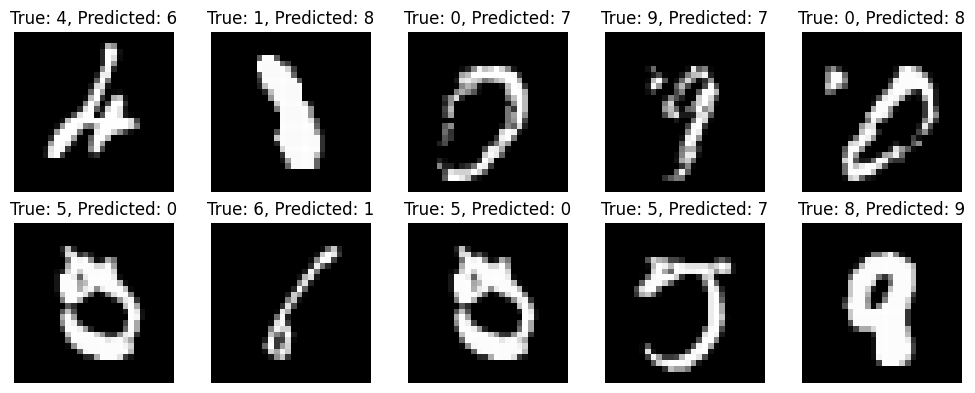

In [25]:
import random
import matplotlib.pyplot as plt

# 잘못 분류된 샘플 중 10개를 랜덤하게 선택하여 출력
print("Wrongly classified samples:")
plt.figure(figsize=(10, 4))  # 전체 그림의 크기 설정
for i in range(10):
    sample = random.choice(wrong_samples)
    input_img, true_label, predicted_label = sample
    plt.subplot(2, 5, i + 1)  # 2행 5열의 subplot 중 i+1 번째에 그림을 출력
    plt.imshow(input_img.squeeze().cpu().numpy(), cmap='gray')
    plt.title(f'True: {true_label}, Predicted: {predicted_label}')
    plt.axis('off')  # 축 제거
plt.tight_layout()  # subplot 간격 자동 조절
plt.show()

맞게 분류된 샘플 랜덤 선택 출력

Correctly classified samples:


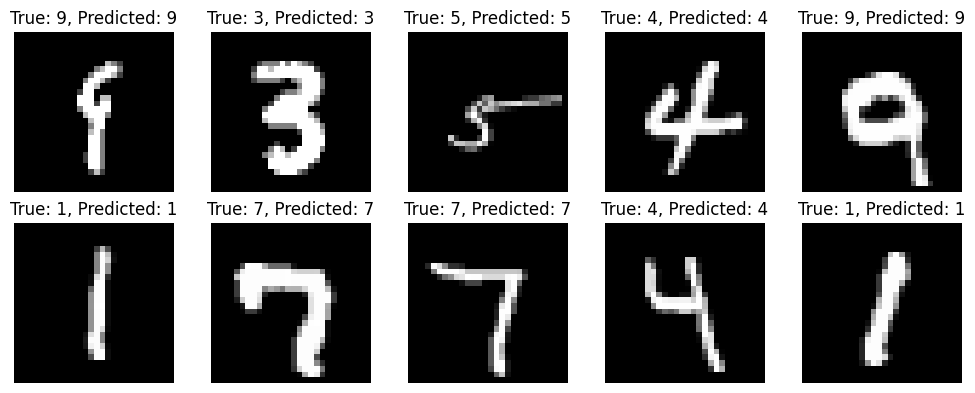

In [26]:
# 정확하게 분류된 샘플 중 10개를 랜덤하게 선택하여 출력
print("Correctly classified samples:")
plt.figure(figsize=(10, 4))  # 전체 그림의 크기 설정
for i in range(10):
    sample = random.choice(correct_samples)
    input_img, true_label, predicted_label = sample
    plt.subplot(2, 5, i + 1)  # 2행 5열의 subplot 중 i+1 번째에 그림을 출력
    plt.imshow(input_img.squeeze().cpu().numpy(), cmap='gray')
    plt.title(f'True: {true_label}, Predicted: {predicted_label}')
    plt.axis('off')  # 축 제거
plt.tight_layout()  # subplot 간격 자동 조절
plt.show()

#### TEST2 : 표준편차 0.6 가우시안 노이즈를 적용한 테스트 데이터셋을 사용하여 테스트

In [27]:
from skimage.util import random_noise
from torchvision.utils import save_image

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

가우시안 노이즈를 추가하고 노이즈를 추가한 Sample 이미지 확인

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


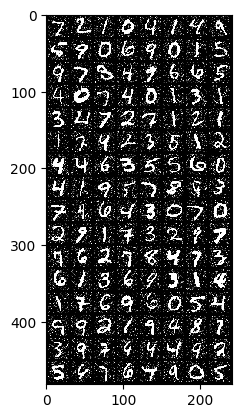

In [30]:
from torchvision import utils

noisy_transform=transforms.Compose([
    #transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    AddGaussianNoise(mean=0., std=0.6),
])

# MNIST test dataset 불러오기
gau_06_test_data = datasets.MNIST(path2data, train=False, download=True, transform=noisy_transform)
gau_06_test_dl = DataLoader(gau_06_test_data, batch_size=128)
# test data를 추출합니다.
x_test, y_test = gau_06_test_data.data, gau_06_test_data.targets

if len(x_test.shape) == 3:
    x_test = x_test.unsqueeze(1)

# tensor를 image로 변경하는 함수를 정의합니다.
def show(img):
    # tensor를 numpy array로 변경합니다.
    npimg = img.numpy()
    # C*H*W를 H*W*C로 변경합니다.
    npimg_tr = npimg.transpose((1,2,0))
    plt.imshow(npimg_tr, interpolation='nearest')

for batch in gau_06_test_dl:
    inputs, targets = (b.to(device) for b in batch)
    x_test_grid = utils.make_grid(inputs, nrow=8, padding=2)
    show(x_test_grid.to('cpu'))
    break


# 아래처럼 x_test로 접근하면 transform을 거치기 전 원본 데이터가 시각화 되므로 위의 코드처럼 순환하여 시각화하는 방식을 사용
#x_test_grid = utils.make_grid(x_test[:40], nrow=8, padding=2)
#show(x_test_grid)

정확도 출력

In [31]:
correct_samples, wrong_samples = check_accuracy(gau_06_test_dl, model)

Accuracy on the test set: 97.870%


틀리게 분류된 샘플 랜덤 선택 출력

Wrongly classified samples:


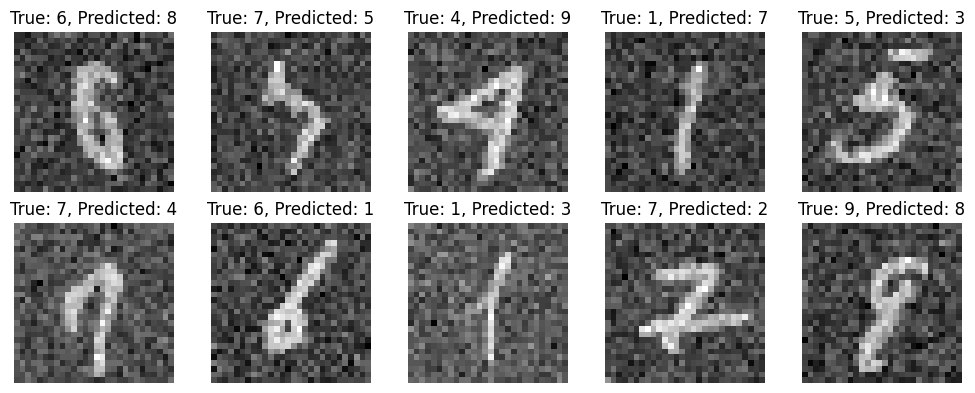

In [37]:
import random
import matplotlib.pyplot as plt

# 잘못 분류된 샘플 중 10개를 랜덤하게 선택하여 출력
print("Wrongly classified samples:")
plt.figure(figsize=(10, 4))  # 전체 그림의 크기 설정
for i in range(10):
    sample = random.choice(wrong_samples)
    input_img, true_label, predicted_label = sample
    plt.subplot(2, 5, i + 1)  # 2행 5열의 subplot 중 i+1 번째에 그림을 출력
    plt.imshow(input_img.squeeze().cpu().numpy(), cmap='gray')
    plt.title(f'True: {true_label}, Predicted: {predicted_label}')
    plt.axis('off')  # 축 제거
plt.tight_layout()  # subplot 간격 자동 조절
plt.show()

맞게 분류된 샘플 랜덤 선택 출력

Correctly classified samples:


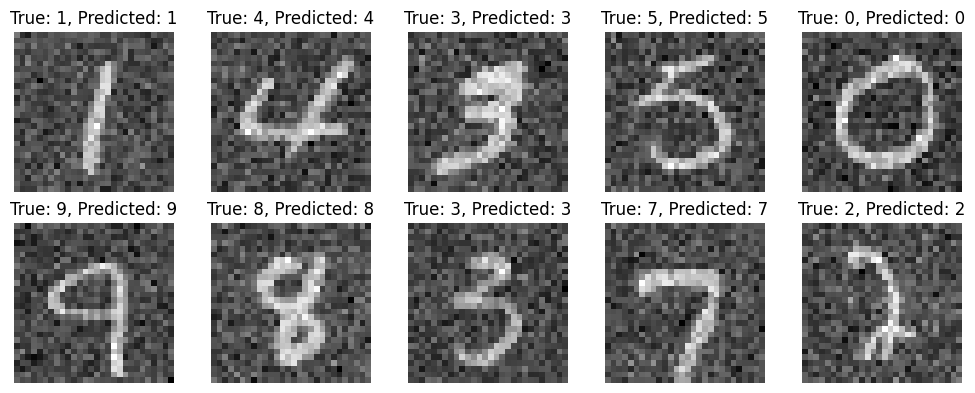

In [38]:
# 정확하게 분류된 샘플 중 10개를 랜덤하게 선택하여 출력
print("Correctly classified samples:")
plt.figure(figsize=(10, 4))  # 전체 그림의 크기 설정
for i in range(10):
    sample = random.choice(correct_samples)
    input_img, true_label, predicted_label = sample
    plt.subplot(2, 5, i + 1)  # 2행 5열의 subplot 중 i+1 번째에 그림을 출력
    plt.imshow(input_img.squeeze().cpu().numpy(), cmap='gray')
    plt.title(f'True: {true_label}, Predicted: {predicted_label}')
    plt.axis('off')  # 축 제거
plt.tight_layout()  # subplot 간격 자동 조절
plt.show()

### 5. 인용

~~~
@inproceedings{foret2021sharpnessaware,
  title={Sharpness-aware Minimization for Efficiently Improving Generalization},
  author={Pierre Foret and Ariel Kleiner and Hossein Mobahi and Behnam Neyshabur},
  booktitle={International Conference on Learning Representations},
  year={2021},
  url={https://openreview.net/forum?id=6Tm1mposlrM}
}
~~~

~~~
@inproceesings{pmlr-v139-kwon21b,
  title={ASAM: Adaptive Sharpness-Aware Minimization for Scale-Invariant Learning of Deep Neural Networks},
  author={Kwon, Jungmin and Kim, Jeongseop and Park, Hyunseo and Choi, In Kwon},
  booktitle ={Proceedings of the 38th International Conference on Machine Learning},
  pages={5905--5914},
  year={2021},
  editor={Meila, Marina and Zhang, Tong},
  volume={139},
  series={Proceedings of Machine Learning Research},
  month={18--24 Jul},
  publisher ={PMLR},
  pdf={http://proceedings.mlr.press/v139/kwon21b/kwon21b.pdf},
  url={https://proceedings.mlr.press/v139/kwon21b.html},
  abstract={Recently, learning algorithms motivated from sharpness of loss surface as an effective measure of generalization gap have shown state-of-the-art performances. Nevertheless, sharpness defined in a rigid region with a fixed radius, has a drawback in sensitivity to parameter re-scaling which leaves the loss unaffected, leading to weakening of the connection between sharpness and generalization gap. In this paper, we introduce the concept of adaptive sharpness which is scale-invariant and propose the corresponding generalization bound. We suggest a novel learning method, adaptive sharpness-aware minimization (ASAM), utilizing the proposed generalization bound. Experimental results in various benchmark datasets show that ASAM contributes to significant improvement of model generalization performance.}
}
~~~